<a href="https://colab.research.google.com/github/AnjanaGJoseph/Signature_forgery_detection/blob/master/signature_classification_using_siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All imports are defined here:-

In [2]:
import numpy as np 
import pandas as pd
import os

%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import random
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [4]:
!kaggle datasets download -d robinreni/signature-verification-dataset

 99% 593M/601M [00:08<00:00, 99.6MB/s]
100% 601M/601M [00:08<00:00, 73.7MB/s]


In [5]:

!unzip -q signature-verification-dataset.zip

# Defining Training Directories and CSV's:-

In [6]:
train_dir="/content/sign_data/train"
train_csv="/content/sign_data/train_data.csv"
test_csv="/content/sign_data/test_data.csv"
test_dir="/content/sign_data/test"

In [7]:
df_train=pd.read_csv(train_csv)
df_train.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
21905,037/05_037.png,037_forg/01_0123037.PNG,1
15823,036/11_036.png,036_forg/04_0118036.PNG,1
12705,049/10_049.png,049_forg/03_0114049.PNG,1
3286,058/10_058.png,058/03_058.png,0
19581,027/06_027.png,027_forg/02_0101027.PNG,1
6996,024/01_024.png,024/04_024.png,0
6003,002/002_09.PNG,002_forg/0110002_02.png,1
7175,040/03_040.png,040_forg/01_0114040.PNG,1
12198,050/09_050.png,050/01_050.png,0
12937,053/03_053.png,053_forg/01_0107053.PNG,1


# Here we are seeing that 1 denotes for forged pair and 0 denotes for geniune pair of signatures..

In [8]:

df_test=pd.read_csv(test_csv)
df_test.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
1355,051/07_051.png,051_forg/04_0104051.PNG,1
1134,067/03_067.png,067_forg/02_0212067.PNG,1
2307,049/02_049.png,049/11_049.png,0
1303,051/05_051.png,051_forg/04_0120051.PNG,1
1863,055/06_055.png,055_forg/02_0120055.PNG,1
468,062/09_062.png,062/12_062.png,0
2412,053/05_053.png,053_forg/04_0207053.PNG,1
4624,056/06_056.png,056/07_056.png,0
1538,050/09_050.png,050_forg/03_0204050.PNG,1
4365,063/04_063.png,063/11_063.png,0


In [9]:
df_train.shape

(23205, 3)

In [10]:
df_test.shape

(5747, 3)

# Making Custom Pytorch Siamese Dataset:-

the ____len____ function which returns the size of the dataset, and

the ____getitem____ function which returns a sample from the dataset given an index.

In [11]:
df_train[4:5]

,068/09_068.png,068_forg/03_0113068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [12]:
image1_path=os.path.join(train_dir,df_train.iat[4,0])
image1_path

'/content/sign_data/train/068/09_068.png'

In [13]:
class Sign_Data(Dataset):
    def __init__(self,train_dir=None,train_csv=None,transform=None):
        self.train_dir=train_dir
        self.train_data=pd.read_csv(train_csv)
        self.train_data.columns=['image1','image2','class']
        self.transform=transform
        
    def __getitem__(self,idx): ## __getitem__ returns a sample data given index, idx=index
        
        img1_path=os.path.join(self.train_dir,self.train_data.iat[idx,0])
        img2_path=os.path.join(self.train_dir,self.train_data.iat[idx,1])
        
        img1=Image.open(img1_path)
        img2=Image.open(img2_path)
        
        img1=img1.convert('L') #L mode image, that means it is a single channel image - normally interpreted as greyscale.
        img2=img2.convert('L')
        
        img1=self.transform(img1)
        img2=self.transform(img2)
        
        return img1, img2, torch.from_numpy(np.array([int(self.train_data.iat[idx,2])],dtype=np.float32))
    
    
    def __len__(self): ## __len__ returns the size of the dataset..
        return len(self.train_data)

# Returns Image1, Image2 and the class label(whether 0 or 1).

In [14]:
dataset = Sign_Data(train_dir,train_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

In [15]:
dataset

# Siamese Network:-

In [16]:
class SiameseNetwork(nn.Module):
    
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        
        self.conv1=nn.Conv2d(1,50,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # L1 ImgIn shape=(?, 28, 28, 1)      # (n-f+2*p/s)+1
        #    Conv     -> (?, 24, 24, 50)
        #    Pool     -> (?, 12, 12, 50)
        
        
        self.conv2 = nn.Conv2d(50,60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # L2 ImgIn shape=(?, 12, 12, 50)
        #    Conv      ->(?, 8, 8, 60)
        #    Pool      ->(?, 4, 4, 60)
        
        
        self.conv3 = nn.Conv2d(60, 80,  kernel_size = 3)
        # L3 ImgIn shape=(?, 4, 4, 60)
        #    Conv      ->(?, 2, 2, 80)
        
        self.batch_norm1 = nn.BatchNorm2d(50)
        self.batch_norm2 = nn.BatchNorm2d(60)
        
        #self.dropout1 = nn.Dropout2d()
        
        # L4 FC 2*2*80 inputs -> 250 outputs
        self.fc1 = nn.Linear(32000, 128) 
        self.fc2 = nn.Linear(128, 2)
        
      
    
    
    def forward1(self,x):
        x=self.conv1(x)
        x = self.batch_norm1(x)
        x=F.relu(x)
        x=self.pool1(x)
        
        x=self.conv2(x)
        x = self.batch_norm2(x)
        x=F.relu(x)
        x=self.pool2(x)
        
        x=self.conv3(x)
        x=F.relu(x)
#         print(x.size())
        x = x.view(x.size()[0], -1)
#         print('Output2')
#         print(x.size()) #32000 thats why the input of fully connected layer is 32000
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward1(input1)
        # forward pass of input 2
        output2 = self.forward1(input2)
        
        return output1, output2


# Constrastive Loss Function:-

Contrastive loss:-
Contrastive loss is widely-used in unsupervised and self-supervised learning. Originally developed by Hadsell et al. in 2016 from Yann LeCun’s group, this loss function operates on pairs of samples instead of individual samples. It defines a binary indicator Y for each pair of samples stating whether they should be deemed similar, and a learnable distance function D_W(x_1, x_2) between a pair of samples x_1, x_2, parameterized by the weights W in the neural network. 

, where m>0 is a margin. The margin defines a radius around the embedding space of a sample so that dissimilar pairs of samples only contribute to the contrastive loss function if the distance D_W is within the margin.


Intuitively, this loss function encourages the neural network to learn a embedding to place samples with the same labels close to each other, while distancing the samples with different labels in the embedding space.

In [17]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive
    

In [18]:
train_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)

In [19]:
train_dataloader

In [20]:
if torch.cuda.is_available():
    print('Yes')

Yes


In [21]:
device = torch.device("cuda")
net = SiameseNetwork().to(device)

criterion = ContrastiveLoss()               
#optimizer = torch.optim.SGD(net.parameters(), lr = 3e-4) 

optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99)

In [22]:
def train():
    loss= [] 

    for epoch in range(1,10):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))

        loss.append(loss_contrastive.item())
        
    return net

In [28]:
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

Epoch 1
 Current loss 0.6359413862228394

Epoch 2
 Current loss 0.7853760123252869

Epoch 3
 Current loss 0.6955865025520325

Epoch 4
 Current loss 0.8497647047042847

Epoch 5
 Current loss 0.6058153510093689

Epoch 6
 Current loss 0.7251144051551819

Epoch 7
 Current loss 0.6152269244194031

Epoch 8
 Current loss 0.773497462272644

Epoch 9
 Current loss 0.7247729897499084

Model Saved Successfully


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))


<All keys matched successfully>

In [25]:


test_dataset = Sign_Data(test_dir,test_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=8,batch_size=1,shuffle=True)

In [26]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Testing the model by comparing the model's distance prediction between two pairs of Signature:-

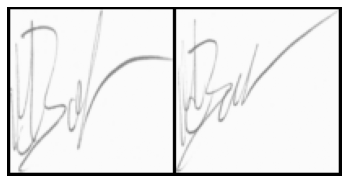

Predicted Eucledian Distance:- 0.6652873754501343
Actual Label:- Original Pair Of Signature


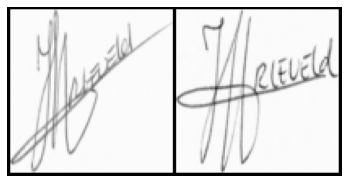

Predicted Eucledian Distance:- 0.6722190976142883
Actual Label:- Forged Pair Of Signature


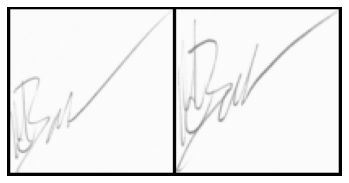

Predicted Eucledian Distance:- 0.29051724076271057
Actual Label:- Original Pair Of Signature


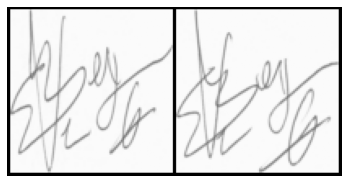

Predicted Eucledian Distance:- 0.6742018461227417
Actual Label:- Original Pair Of Signature


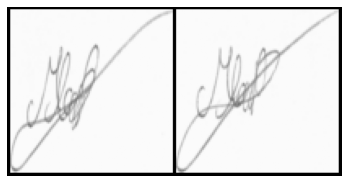

Predicted Eucledian Distance:- 0.2467360496520996
Actual Label:- Original Pair Of Signature


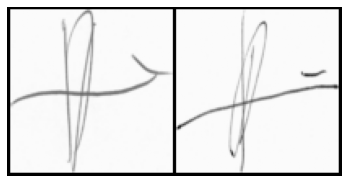

Predicted Eucledian Distance:- 0.5002580881118774
Actual Label:- Forged Pair Of Signature


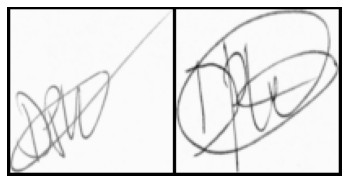

Predicted Eucledian Distance:- 0.7712991833686829
Actual Label:- Forged Pair Of Signature


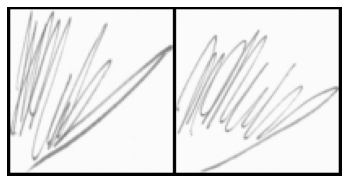

Predicted Eucledian Distance:- 0.5054520964622498
Actual Label:- Original Pair Of Signature


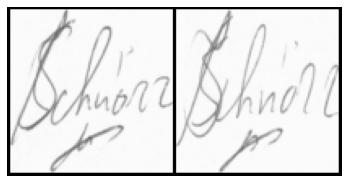

Predicted Eucledian Distance:- 0.37363460659980774
Actual Label:- Original Pair Of Signature


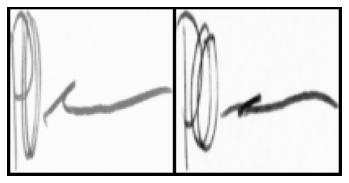

Predicted Eucledian Distance:- 0.6465646624565125
Actual Label:- Forged Pair Of Signature


In [27]:
count=0
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concat = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))

  eucledian_distance = F.pairwise_distance(output1, output2)
    
  if label==torch.FloatTensor([[0]]):
    label="Original Pair Of Signature"
  else:
    label="Forged Pair Of Signature"
    
  imshow(torchvision.utils.make_grid(concat))
  print("Predicted Eucledian Distance:-",eucledian_distance.item())
  print("Actual Label:-",label)
  count=count+1
  if count ==10:
     break

# Mostly our model is predicting the distances quite well.